<a href="https://colab.research.google.com/github/vujjiniashrith/IOT_security/blob/main/cnn_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.models import Model
from tensorflow import keras

In [ ]:
df = pd.read_excel('combined_dataset.xlsx')
columns = df.columns
print(columns)
columns_to_delete = [ 'INOP_PLETH','INOP_SpO2', 'INOP_RESP', 'INOP_NOISE', 'ALARM']
df.drop(columns=columns_to_delete, inplace=True)
print(df.columns)

Index(['SpO2', 'HR', 'PULSE', 'RESP', 'ABP1', 'ABP2', 'ABP3', 'INOP_PLETH',
       'INOP_SpO2', 'INOP_RESP', 'INOP_NOISE', 'ALARM'],
      dtype='object')
Index(['SpO2', 'HR', 'PULSE', 'RESP', 'ABP1', 'ABP2', 'ABP3'], dtype='object')


In [ ]:
df.dropna( inplace = True)
df.reset_index(drop = True, inplace = True)

In [ ]:
df.shape

(83202, 7)

<AxesSubplot:>

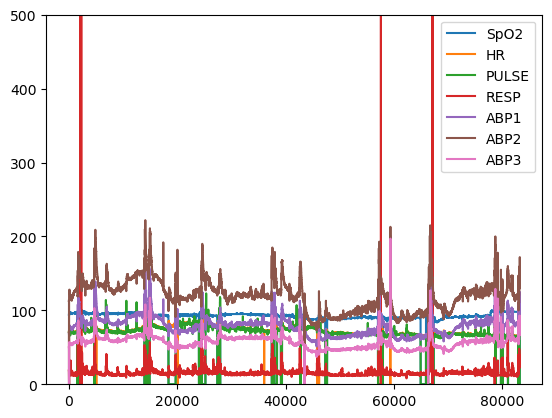

In [ ]:
df.plot(ylim=(0, 500), kind='line')

<AxesSubplot:>

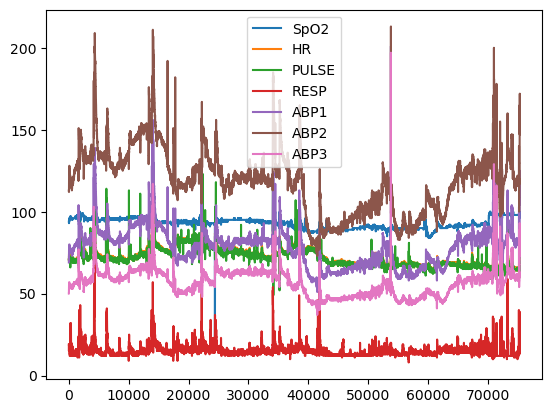

In [ ]:
df = df.loc[(df != 0).all(axis=1)]
df.reset_index(drop = True, inplace = True)
df.plot(kind='line')

In [ ]:
df.shape

(75380, 7)

In [ ]:
scaler1 = StandardScaler()
scaler2 = StandardScaler()
data = df.values

In [ ]:
train_ratio = 0.8

test_ratio = 0.2

In [ ]:
length = len(data)

In [ ]:
X_train = data[:int(train_ratio*length)]
X_test = data[int((train_ratio) * length):]

In [ ]:
X_train = scaler1.fit_transform(X_train)
X_test = scaler2.fit_transform(X_test)

In [ ]:
print(len(X_train), len(X_test))

60304 15076


In [ ]:
print(X_train.shape, X_test.shape)

(60304, 7) (15076, 7)


In [ ]:
lookback = 128
reshaped_train = []
reshaped_test= []

for i in range(len(X_train)-lookback+1):
    sample_train = X_train[i:i+lookback]
    reshaped_train.append(sample_train)
reshaped_train = np.array(reshaped_train)


for i in range(len(X_test)-lookback+1):
    sample_test = X_test[i:i+lookback]
    reshaped_test.append(sample_test)
reshaped_test = np.array(reshaped_test)


In [ ]:
print(reshaped_train.shape,reshaped_test.shape)

(60177, 128, 7) (14949, 128, 7)


In [ ]:
num_features = 7
input_shape = (lookback, 7)

input_layer = Input(shape=input_shape)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=4, padding='same')(x)
x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(pool_size=4, padding='same')(x)

x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(encoded)
x = UpSampling1D(size=4)(x)
x = Conv1D(32, kernel_size=3, activation='relu', padding='same')(x)
x = UpSampling1D(size=4)(x)
decoded = Conv1D(num_features, kernel_size=3, activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 7)]          0         
                                                                 
 conv1d (Conv1D)             (None, 128, 32)           704       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 32, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 64)            6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 64)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 8, 64)             12352 

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)#do not run this if you have latest version of tensorflow

In [ ]:
autoencoder.fit(reshaped_train, reshaped_train, epochs=10, batch_size=30, validation_data=(reshaped_test, reshaped_test))

Epoch 1/10
   1/2006 [..............................] - ETA: 2:45 - loss: 1.1563

C:\Users\vujji\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\data\ops\dataset_ops.py:4526: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2006/2006 [==============================] - 56s 28ms/step - loss: 0.6028 - val_loss: 0.6065
Epoch 2/10
2006/2006 [==============================] - 60s 30ms/step - loss: 0.5926 - val_loss: 0.6015
Epoch 3/10
1835/2006 [==========================>...] - ETA: 4s - loss: 0.5927

KeyboardInterrupt: 

In [ ]:
tf.data.experimental.enable_debug_mode()

In [ ]:
smoothed_test_data = autoencoder.predict(reshaped_test)

In [ ]:
last_value_test = smoothed_test_data[:,-1,:]
output_data_test = last_value_test.reshape(-1, last_value_test.shape[-1])

In [ ]:
output_data_test.shape

(14949, 7)

In [ ]:
output_df_test = pd.DataFrame(scaler2.inverse_transform(output_data_test),columns=df.columns)

In [ ]:
input_df_test = pd.DataFrame(scaler2.inverse_transform(X_test),columns=df.columns)

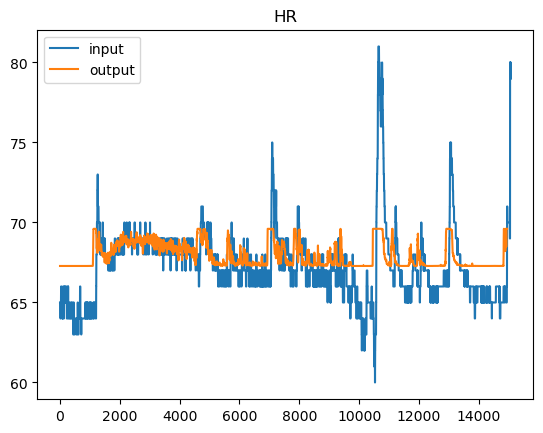

In [ ]:
plt.title("HR")
plt.plot(input_df_test.HR, label='input')
plt.plot(output_df_test.HR, label='output')
plt.legend()
plt.show()


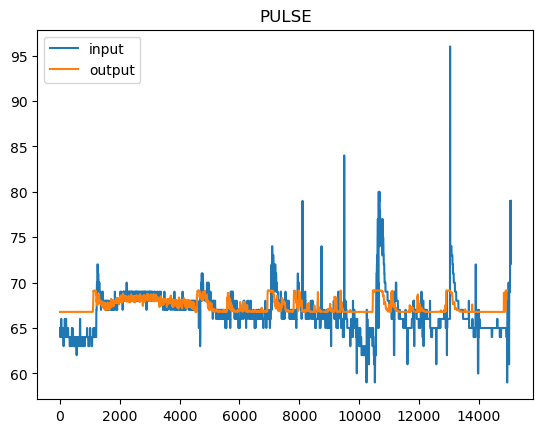

In [ ]:

plt.title("PULSE")
plt.plot(input_df_test.PULSE, label='input')
plt.plot(output_df_test.PULSE, label='output')
plt.legend()
plt.show()

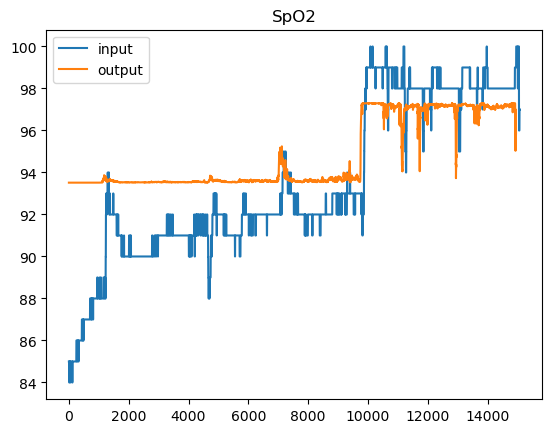

In [ ]:
plt.title("SpO2")
plt.plot(input_df_test.SpO2, label='input')
plt.plot(output_df_test.SpO2, label='output')
plt.legend()
plt.show()

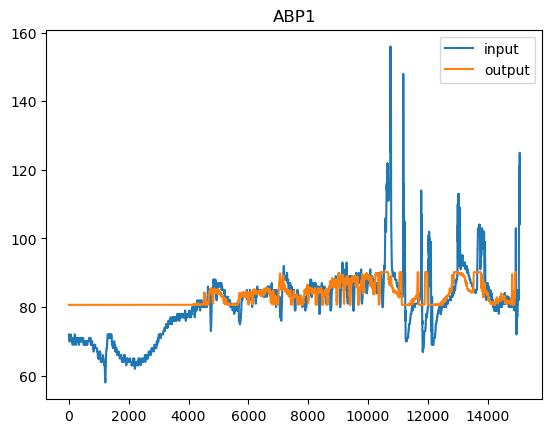

In [ ]:
plt.title("ABP1")
plt.plot(input_df_test.ABP1, label='input')
plt.plot(output_df_test.ABP1, label='output')
plt.legend()
plt.show()

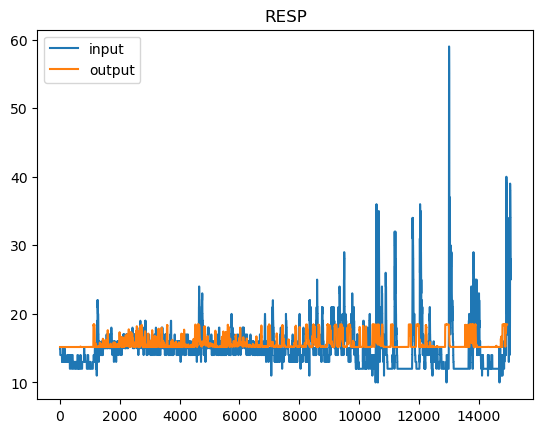

In [ ]:
plt.title("RESP")
plt.plot(input_df_test.RESP, label='input')
plt.plot(output_df_test.RESP, label='output')
plt.legend()
plt.show()